In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from dlisio import dlis
import numpy as np
from os.path import join as pjoin
import pandas as pd

In [2]:
root = '/raid/CCED-internal/supervised-sinusoid-detection/Prediction PDF/depth_dip_azimuth/CCED-Sinusoid-Detection-Ray-NewData-30-focalloss/0.0003963017800870864_200_resnet18_l1_focal_1682700067.9926434/dataset_5bb0053f44644fd4a81a9fc856aaa772/SH R-1H1/'
gt_fname = 'GTReservoirZone.csv'
pred_fname = 'PredReservoirZone.csv'
rawData = '../rawData/SH R-1H1'
dlisFileName = 'SH H-14_PROCFMIDYN_SLB_26NOV2021.dlis'

In [3]:
wellName = rawData.split('/')[-1]

In [4]:
pred = pd.read_csv(pjoin(root, pred_fname))
gt = pd.read_csv(pjoin(root, gt_fname))

In [5]:
def inchToMeter(tdep_array):
    print('Converting inch to meters')
    depth_in = tdep_array/10
    depth_ft = depth_in*0.0833333
    tdep_array = depth_ft*0.3048
    return tdep_array

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def calculateAmpPhase(dip_deg,azi_deg,rwell):
    dip_rad = dip_deg*(np.pi/180)
    amp = np.tan(dip_rad)*rwell
    azi_rad = azi_deg*(np.pi/180)
    phase =  np.pi/2 - azi_rad
    return amp, phase  

def createSinusoid(amp,phase):
    w=0.0175
    fitfunc = lambda t:  amp*np.sin(w*t + phase)
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(0, 360,1) 
    # calculate the output for the range
    y_line = fitfunc(x_line)
    return x_line, y_line 

In [6]:
dlisFile = dlis.load(pjoin(rawData, dlisFileName))

#get correct logical file as per user input
if len(dlisFile)>1:
    logicalFile = [i for i in dlisFile if 'dyn' in str(i).lower()][0]
    print('Dynamic Logical file retrieved')
else:
    logicalFile = dlisFile[0]
    print('Logical file retrieved')

depthChannelIdx, depthChannel = [(i, channel) for i, channel in enumerate(logicalFile.channels) if channel.name in ['TDEP', 'MD', 'DEPTH']][-1]
fmiChannelIdx, fmiChannel = [(i, channel) for i, channel in enumerate(logicalFile.channels) if channel.name in ['FMI_DYN', 'CMI_DYN']][-1]

tdep_array = logicalFile.channels[depthChannelIdx].curves()
print('{} Loaded'.format(depthChannel.name))
print("Shape of {} Array: {}".format(depthChannel.name, tdep_array.shape))
print("Original Depth Array: {}".format(tdep_array))
print("Unit of the given depth is {}".format(depthChannel.units))

if depthChannel.units.endswith('in'):
    tdep_array = inchToMeter(tdep_array)
    print("Depth Array after conversion: {}".format(tdep_array))
else:
    if tdep_array[0]>5000:
        tdep_array = inchToMeter(tdep_array)
        print("Depth Array after conversion: {}".format(tdep_array))

fmi_array = logicalFile.channels[fmiChannelIdx].curves()
print('{} Loaded'.format(fmiChannel.name))
print("Shape of {} Array: {}".format(fmiChannel.name, fmi_array.shape))

if tdep_array[0]>tdep_array[-1]:
    fmi_array = fmi_array[::-1]
    tdep_array = tdep_array[::-1]
    print('Reversing the FMI & Depth Arrays')
else:
    print("Reversing Arrays not required")

fmi_array[fmi_array == -9999.] = np.ma.masked_equal(fmi_array, -9999.0, copy=False).min()

Logical file retrieved
TDEP Loaded
Shape of TDEP Array: (697502,)
Original Depth Array: [1154462. 1154461. 1154460. ...  456963.  456962.  456961.]
Unit of the given depth is 0.1 in
Converting inch to meters
Depth Array after conversion: [2932.33230707 2932.32976707 2932.32722707 ... 1160.68555573 1160.68301573
 1160.68047573]
FMI_DYN Loaded
Shape of FMI_DYN Array: (697502, 360)
Reversing the FMI & Depth Arrays


In [7]:
zoneStart, zoneEnd = min(pred['Depth'].min(), gt['Depth'].min()) - 0.1, max(gt['Depth'].max(), pred['Depth'].max()) + 0.1

mask = (tdep_array >= zoneStart) & (tdep_array <= zoneEnd)
fmi_array = fmi_array[mask]
tdep_array = tdep_array[mask]

In [45]:
def plot_sinusoids(DOI, dep, ax, linewidth, bbColor, Fcolor):

    for row in DOI.iterrows():
        row = row[1]
        amp, phase = calculateAmpPhase(row["Dip"],row["Azimuth"],0.108)
        x_line, y_line = createSinusoid(amp,phase)
        y_line = y_line + row.Depth
        new_y = []
        for i in y_line:
            new_y.append(find_nearest(dep, i))
        if row.Type == 'Bb':
            ax.plot(new_y, bbColor, linewidth = linewidth)
        else:
            ax.plot(new_y, Fcolor, linewidth = linewidth)

def tadpolePlotGTComparison(df, ax, sinTypeStart, color, scaler):

    for rows in df.iterrows():
        if rows[1].Type.lower().startswith(sinTypeStart.lower()):

            ax.plot(rows[1].Dip, int(scaler.transform([[rows[1].Depth]])), marker = '.', markersize = 10, 
                    color = color)
            ax.plot(rows[1].Dip, int(scaler.transform([[rows[1].Depth]])), marker = (1, 2, -rows[1].Azimuth), 
                    markersize = 40, color = color)

def comparison_plot(fmiZone, tdepZone, zoneStart, gtZone,  predZone, zoneEnd, tadpoleScaler, fmiRatio, fontSize, linewidth, 
                    save_path, dpi = 50, figsize = (20, 25), save = True, split = False):
    _, ax = plt.subplots(1, 4, sharey = True, figsize = figsize,
                         gridspec_kw = {'width_ratios': [fmiRatio, fmiRatio, fmiRatio, 1]})
    
    ax[0].imshow(fmiZone, cmap = 'YlOrBr')
    ax[1].imshow(fmiZone, cmap = 'YlOrBr')
    ax[2].imshow(fmiZone, cmap = 'YlOrBr')
    ax[3].imshow(np.zeros((fmiZone.shape[0], 90)), cmap = 'gray', vmin = -10, vmax = 0)
    
    plt.yticks(np.linspace(0, tdepZone.shape[0], 10), np.linspace(zoneStart, zoneEnd, 10).round(2))
    ax[0].tick_params(axis = 'y', labelsize = fontSize + 5)

    ax[0].set_xticks([])
    ax[1].set_xticks([])
    ax[2].set_xticks([])
    ax[3].set_xticks([0, 30, 60, 90])
    ax[3].tick_params(axis = 'x', labelsize = fontSize - 5)
    
    vlines = list(range(0, 100, 10))
    ax[3].vlines(vlines, ymin = 0, ymax = tdepZone.shape[0] - 1, linestyles = 'dotted')
    ax[3].set_xlim(-10, 100)
    
    plot_sinusoids(gtZone, tdepZone, ax[1], linewidth, 'red', 'black')
    plot_sinusoids(predZone, tdepZone, ax[2], linewidth, 'green', 'blue')
    tadpolePlotGTComparison(gtZone, ax[3], 'F', 'black', tadpoleScaler)
    tadpolePlotGTComparison(predZone, ax[3], 'F', 'blue', tadpoleScaler)

    
    ax[0].set_title('Input Image', fontsize = fontSize)
    ax[1].set_title('Ground Truth\nBb: Green\nFrac: Blue', fontsize = fontSize)
    ax[2].set_title('Prediction\nBb: Green\nFrac: Blue', fontsize = fontSize)
    ax[3].set_title('Fracture\nGT: Black\nPred: Blue', fontsize = fontSize)
    
    plt.tight_layout()
    
    if save:
        if split:
            fname = save_path
        else:
            fname = pjoin(save_path, '{}m - {}m.pdf'.format(round(tdepZone[0], 2), round(tdepZone[-1], 2)))
        plt.savefig(fname, format = 'pdf', dpi = dpi, bbox_inches = 'tight')
        plt.close()
    else:
        plt.show()

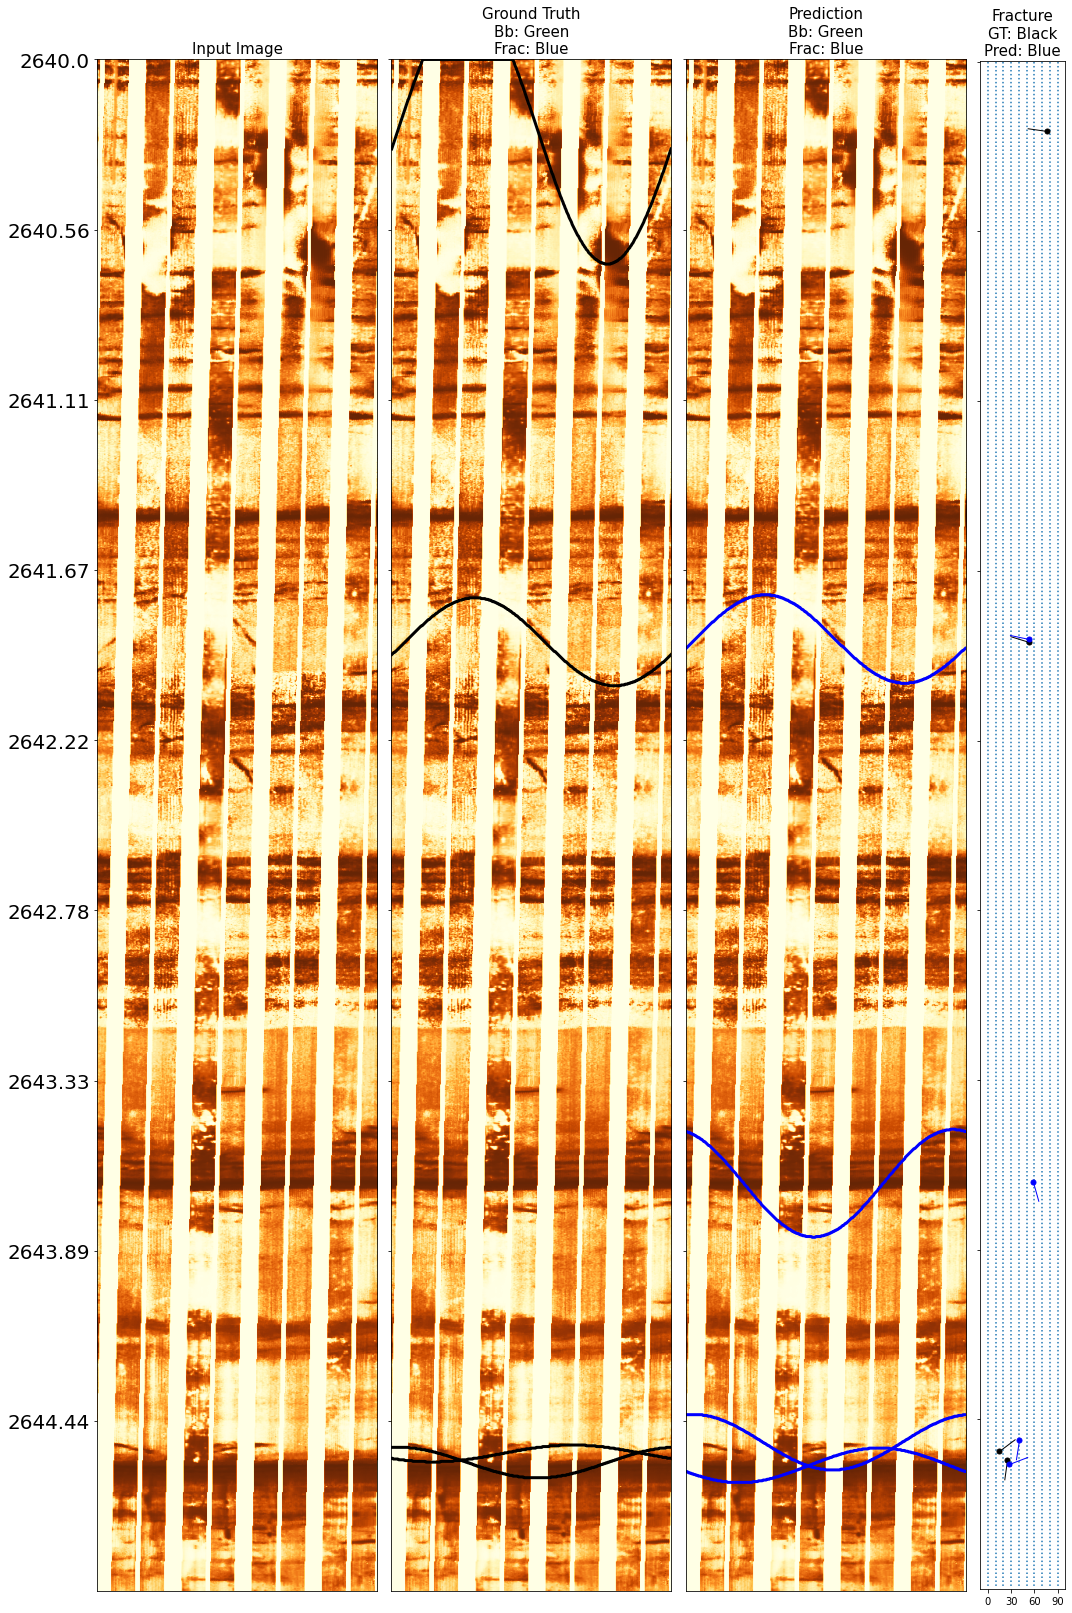

In [72]:
zoneStart, zoneEnd = 2640, 2645
fontSize = 15
tadpoleLength = 600

idx_start = find_nearest(tdep_array, zoneStart)
idx_end = find_nearest(tdep_array, zoneEnd)

fmiZone = fmi_array[idx_start:idx_end]
tdepZone = tdep_array[idx_start:idx_end]

windowSize = fmiZone.shape[0]
fmiLength = fmiZone.shape[0]
fmiRatio = fmiLength/tadpoleLength

gtZone = gt[(gt.Depth>=zoneStart) & (gt.Depth<=zoneEnd)]
predZone = pred[(pred.Depth>=zoneStart) & (pred.Depth<=zoneEnd)]

tadpoleScaler = MinMaxScaler((0, fmiZone.shape[0]))
tadpoleScaler.fit([[zoneStart], [zoneEnd]])

comparison_plot(fmiZone, tdepZone, zoneStart, gtZone,  predZone, zoneEnd, tadpoleScaler, fmiRatio, fontSize, 3, 
                None, 300, (15, 30), save = False)